In [30]:
import gurobipy as gp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time

%matplotlib inline

from markowitz import Markowitz

In [31]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

### Leitura e pré-processamento dos dados de entrada:

In [32]:
df = pd.read_excel('seriehistorica10anos.xlsx')
df.fillna(method='ffill',inplace=True)
df.rename(columns={df.columns[0]: 'datas'},
          inplace=True, errors='raise')

df['datas'] = pd.to_datetime(df['datas'])
df.set_index('datas', inplace = True)

### PARA DROPAR AS ENTRADAS NULAS:
#df = df[(df != 0).all(1)]

### PARA APLICAR UMA INTERPOLAÇÃO NO PERÍODO 
df = df.replace(0, pd.NA).interpolate()

In [33]:
#for col in df:
#    print(df[col] [df[col] <= 0.0001])

In [34]:
#df['11182072000113']['2019-02']

In [35]:
#df['11182072000113']['2019-02'].replace(0, pd.NA).interpolate()

#fig = plt.figure() 
#plt.figure(figsize=(16,12))
#plt.plot(df['11182072000113']['2019-02'].replace(0, pd.NA).interpolate())
#plt.plot(df['11182072000113']['2019-02'])
#plt.ylim((4.5,5.5))
#plt.grid()
#plt.show()


In [36]:
datas = list(df.index.astype(str))
aux = [i[0:4] for i in datas]
anos = pd.Series(aux).unique().tolist()

limites_anos = [0]

a = 0

for c in anos:
    a += aux.count(c)
    limites_anos.append(a)

print(anos)

['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [37]:
limites_anos

[0, 82, 333, 586, 839, 1089, 1340, 1589, 1839, 2092, 2348, 2522]

### Construção de DF_anos e DF_meses (Não utilizados na atual implementação)

In [38]:
DF_anos = dict()

for k in anos:
    DF_anos[k] = df.loc[k].copy()

In [39]:
DF_meses = dict()

for j in anos:
    for k in range(1, 13):
        try:
            DF_meses[j, str(k).zfill(2)] = df.loc[j + '-' + str(k)].copy()
        except:
            pass
        
DF_meses.keys()

dict_keys([('2011', '09'), ('2011', '10'), ('2011', '11'), ('2011', '12'), ('2012', '01'), ('2012', '02'), ('2012', '03'), ('2012', '04'), ('2012', '05'), ('2012', '06'), ('2012', '07'), ('2012', '08'), ('2012', '09'), ('2012', '10'), ('2012', '11'), ('2012', '12'), ('2013', '01'), ('2013', '02'), ('2013', '03'), ('2013', '04'), ('2013', '05'), ('2013', '06'), ('2013', '07'), ('2013', '08'), ('2013', '09'), ('2013', '10'), ('2013', '11'), ('2013', '12'), ('2014', '01'), ('2014', '02'), ('2014', '03'), ('2014', '04'), ('2014', '05'), ('2014', '06'), ('2014', '07'), ('2014', '08'), ('2014', '09'), ('2014', '10'), ('2014', '11'), ('2014', '12'), ('2015', '01'), ('2015', '02'), ('2015', '03'), ('2015', '04'), ('2015', '05'), ('2015', '06'), ('2015', '07'), ('2015', '08'), ('2015', '09'), ('2015', '10'), ('2015', '11'), ('2015', '12'), ('2016', '01'), ('2016', '02'), ('2016', '03'), ('2016', '04'), ('2016', '05'), ('2016', '06'), ('2016', '07'), ('2016', '08'), ('2016', '09'), ('2016', '10'

### Parâmetros de entrada do modelo:

In [69]:
minRetorno = 0.1
C = 100_000
P_categorias = [0.50, 0.10, 0.35, 0.35] #[0.00, 0.00, 0.00, 1.0]
K_min = 3
K_max = 10
P_min = 0.05
P_max = 0.3
l = 1
log = 0

### Seleção do Período do Estudo - O período final é onde a janela TERMINA, e não o início do período final:

In [70]:
ano_inicial = 2012
ano_final = 2017
mes_inicial = 1
mes_final = 1
intervalo_mensal = 6

In [71]:
pf = pd.read_excel('perfilfundos.xlsx', usecols = ['CNPJ', 'APLICACAO_MINIMA', 'CATEGORIA', 'SUBCATEGORIA'])
pf['CNPJ'] = pf['CNPJ'].apply(lambda x: re.sub('\W+', '', x))
pf['APLICACAO_MINIMA'] = pd.to_numeric(pf['APLICACAO_MINIMA'].apply(lambda x : re.sub('\D+', '', x)), errors='coerce')
pf.fillna(0, inplace=True)
pf.set_index('CNPJ',inplace=True)
pf_ordered = pf.sort_values(by ='CATEGORIA')
pf_ordered.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)

cnpj = list(pf_ordered.index)
    
df = df[cnpj]
categorias = list(pf_ordered['CATEGORIA'].unique())
limites = [0]
a = 0
for c in categorias:
    a += len(pf_ordered[pf_ordered['CATEGORIA'] == c])
    limites.append(a)

minFundos = np.array(pf_ordered['APLICACAO_MINIMA'])

n = len(minFundos)

In [72]:
tam_treinamento = 252*2
tam_teste = 44
inicio_treinamento = 0
final_treinamento = inicio_treinamento + tam_treinamento
inicio_teste = final_treinamento + 1
final_teste = inicio_teste + tam_teste

cnpj = list(pf_ordered.index)

DF_retorno_completo = df.pct_change().dropna()

matriz_pesos = DF_retorno_completo.copy()
matriz_pesos = matriz_pesos * 0

while(final_teste <= DF_retorno_completo.shape[0]):
    minRetorno = 0
    a_retorno = []
    a_risco = []
    a_sharpe = []

    RES = dict()
    k = 0
    
    DF_retorno_treinamento = DF_retorno_completo.iloc[inicio_treinamento:final_treinamento]
   
    sigma = (DF_retorno_treinamento.cov() * 252).to_numpy()
    media = (DF_retorno_treinamento + 1).apply(geo_mean)**252-1
    
    modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
    n, minFundos, sigma, media, cnpj)
    
    tempo_init = time.time()
    while minRetorno <= 0.7:
        print('minRetorno atual:', minRetorno)
        Carteira = modelo.solve(time = 15)
        if(Carteira.Retorno != 0):
            a_retorno.append(Carteira.Retorno)
            a_risco.append(Carteira.Risco)
            a_sharpe.append((Carteira.Retorno - 0.0525)/Carteira.Risco)
        else:
            break
        RES[k] = Carteira
        minRetorno = minRetorno + 0.02
        modelo.update_minRetorno(minRetorno)
        k += 1
    max_i = np.argmax(a_sharpe)
    Carteira = RES[max_i]
    
    #Carteira = modelo.solve()
    print('Tempo total:', time.time() - tempo_init, 's')

    Carteira.exibir(C)

    #hist[str(inicio_treinamento), str(final_treinamento)] = Carteira
#    print('Resultado referente a slice: ', inicio_treinamento + '-' + final_treinamento)
    print('\n')
    print('###############################################')
    print('\n')

    for idx, cnpj_loop in enumerate(Carteira.descricao):
        matriz_pesos[cnpj_loop][inicio_teste:final_teste] = Carteira.porcentagem[idx]
    
    inicio_treinamento += tam_teste
    final_treinamento += tam_teste
    
    inicio_teste += tam_teste
    final_teste += tam_teste

minRetorno atual: 0
minRetorno atual: 0.02
minRetorno atual: 0.04
minRetorno atual: 0.06
minRetorno atual: 0.08
minRetorno atual: 0.1
minRetorno atual: 0.12000000000000001
minRetorno atual: 0.14
minRetorno atual: 0.16
minRetorno atual: 0.18
minRetorno atual: 0.19999999999999998
minRetorno atual: 0.21999999999999997
minRetorno atual: 0.23999999999999996
minRetorno atual: 0.25999999999999995
minRetorno atual: 0.27999999999999997
Nenhuma solucao encontrada!
Tempo total: 4.259012222290039 s
Retorno esperado --> 18.0%
Risco estimado --> 3.01%
Fundo 28 (06118222000190) --> 9.9%; R$ 9901.93 --> R$ 5000.0
Fundo 52 (12004203000135) --> 10.1%; R$ 10098.07 --> R$ 5000.0
Fundo 60 (01430938000104) --> 10.0%; R$ 10000.0 --> R$ 5000.0
Fundo 63 (11182072000113) --> 10.0%; R$ 10000.0 --> R$ 10000.0
Fundo 64 (13503226000157) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 85 (06041290000106) --> 10.0%; R$ 10000.0 --> R$ 1000.0
Fundo 97 (08815403000109) --> 10.0%; R$ 10000.0 --> R$ 10000.0
Fundo 130 (10326625000

minRetorno atual: 0
minRetorno atual: 0.02
minRetorno atual: 0.04
minRetorno atual: 0.06
minRetorno atual: 0.08
minRetorno atual: 0.1
minRetorno atual: 0.12000000000000001
minRetorno atual: 0.14
minRetorno atual: 0.16
minRetorno atual: 0.18
minRetorno atual: 0.19999999999999998
minRetorno atual: 0.21999999999999997
minRetorno atual: 0.23999999999999996
Nenhuma solucao encontrada!
Tempo total: 2.164621353149414 s
Retorno esperado --> 16.0%
Risco estimado --> 2.82%
Fundo 15 (12565159000132) --> 20.0%; R$ 20000.0 --> R$ 20000.0
Fundo 60 (01430938000104) --> 10.0%; R$ 10000.0 --> R$ 5000.0
Fundo 64 (13503226000157) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 102 (11701985000107) --> 17.31%; R$ 17312.79 --> R$ 1000.0
Fundo 106 (11301137000100) --> 7.23%; R$ 7231.42 --> R$ 5000.0
Fundo 118 (09586692000176) --> 5.46%; R$ 5455.79 --> R$ 1000.0
Fundo 130 (10326625000100) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 151 (11447124000136) --> 30.0%; R$ 30000.0 --> R$ 1000.0


##############################

Fundo 151 (11447124000136) --> 29.59%; R$ 29592.24 --> R$ 1000.0


###############################################


minRetorno atual: 0
minRetorno atual: 0.02
minRetorno atual: 0.04
minRetorno atual: 0.06
minRetorno atual: 0.08
minRetorno atual: 0.1
minRetorno atual: 0.12000000000000001
minRetorno atual: 0.14
minRetorno atual: 0.16
minRetorno atual: 0.18
minRetorno atual: 0.19999999999999998
minRetorno atual: 0.21999999999999997
minRetorno atual: 0.23999999999999996
minRetorno atual: 0.25999999999999995
Nenhuma solucao encontrada!
Tempo total: 27.77959656715393 s
Retorno esperado --> 16.0%
Risco estimado --> 2.39%
Fundo 15 (12565159000132) --> 20.0%; R$ 20000.0 --> R$ 20000.0
Fundo 60 (01430938000104) --> 10.0%; R$ 10000.0 --> R$ 5000.0
Fundo 68 (13001211000190) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 69 (04455632000109) --> 10.4%; R$ 10396.99 --> R$ 10000.0
Fundo 81 (06301947000119) --> 14.6%; R$ 14603.01 --> R$ 1000.0
Fundo 102 (11701985000107) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fund

minRetorno atual: 0.32
minRetorno atual: 0.34
minRetorno atual: 0.36000000000000004
minRetorno atual: 0.38000000000000006
minRetorno atual: 0.4000000000000001
minRetorno atual: 0.4200000000000001
minRetorno atual: 0.4400000000000001
minRetorno atual: 0.46000000000000013
minRetorno atual: 0.48000000000000015
minRetorno atual: 0.5000000000000001
Nenhuma solucao encontrada!
Tempo total: 5.372482776641846 s
Retorno esperado --> 16.02%
Risco estimado --> 2.02%
Fundo 17 (09143435000160) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 50 (12082452000149) --> 20.0%; R$ 20000.0 --> R$ 20000.0
Fundo 60 (01430938000104) --> 5.36%; R$ 5355.91 --> R$ 5000.0
Fundo 102 (11701985000107) --> 29.64%; R$ 29644.09 --> R$ 1000.0
Fundo 125 (12120451000141) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 132 (09720734000110) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 139 (02603461000184) --> 20.0%; R$ 20000.0 --> R$ 20000.0
Fundo 149 (10783480000168) --> 10.0%; R$ 10000.0 --> R$ 100.0


########################################

minRetorno atual: 0.18
minRetorno atual: 0.19999999999999998
minRetorno atual: 0.21999999999999997
minRetorno atual: 0.23999999999999996
minRetorno atual: 0.25999999999999995
minRetorno atual: 0.27999999999999997
minRetorno atual: 0.3
minRetorno atual: 0.32
minRetorno atual: 0.34
minRetorno atual: 0.36000000000000004
Nenhuma solucao encontrada!
Tempo total: 6.0696094036102295 s
Retorno esperado --> 16.01%
Risco estimado --> 2.52%
Fundo 17 (09143435000160) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 22 (09550197000107) --> 5.0%; R$ 5000.0 --> R$ 500.0
Fundo 29 (10382858000111) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 55 (11447072000106) --> 5.0%; R$ 5000.0 --> R$ 500.0
Fundo 60 (01430938000104) --> 10.0%; R$ 10000.0 --> R$ 5000.0
Fundo 102 (11701985000107) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 115 (09620860000100) --> 20.22%; R$ 20217.51 --> R$ 1000.0
Fundo 125 (12120451000141) --> 9.78%; R$ 9782.49 --> R$ 1000.0
Fundo 132 (09720734000110) --> 30.0%; R$ 30000.0 --> R$ 1000.0
Fundo 151 (114

minRetorno atual: 0
minRetorno atual: 0.02
minRetorno atual: 0.04
minRetorno atual: 0.06
minRetorno atual: 0.08
minRetorno atual: 0.1
minRetorno atual: 0.12000000000000001
minRetorno atual: 0.14
minRetorno atual: 0.16
minRetorno atual: 0.18
minRetorno atual: 0.19999999999999998
minRetorno atual: 0.21999999999999997
minRetorno atual: 0.23999999999999996
minRetorno atual: 0.25999999999999995
minRetorno atual: 0.27999999999999997
minRetorno atual: 0.3
minRetorno atual: 0.32
Nenhuma solucao encontrada!
Tempo total: 3.0748226642608643 s
Retorno esperado --> 18.0%
Risco estimado --> 3.54%
Fundo 15 (12565159000132) --> 20.0%; R$ 20000.0 --> R$ 20000.0
Fundo 60 (01430938000104) --> 10.0%; R$ 10000.0 --> R$ 5000.0
Fundo 62 (09601190000177) --> 9.28%; R$ 9275.67 --> R$ 0.0
Fundo 110 (09577092000141) --> 25.72%; R$ 25724.33 --> R$ 25000.0
Fundo 127 (09326708000101) --> 28.05%; R$ 28045.43 --> R$ 5000.0
Fundo 152 (13615411000133) --> 6.95%; R$ 6954.57 --> R$ 5000.0


##############################

minRetorno atual: 0
minRetorno atual: 0.02
minRetorno atual: 0.04
minRetorno atual: 0.06
minRetorno atual: 0.08
minRetorno atual: 0.1
minRetorno atual: 0.12000000000000001
minRetorno atual: 0.14
minRetorno atual: 0.16
minRetorno atual: 0.18
minRetorno atual: 0.19999999999999998
minRetorno atual: 0.21999999999999997
minRetorno atual: 0.23999999999999996
minRetorno atual: 0.25999999999999995
minRetorno atual: 0.27999999999999997
minRetorno atual: 0.3
Nenhuma solucao encontrada!
Tempo total: 2.8227789402008057 s
Retorno esperado --> 18.0%
Risco estimado --> 6.8%
Fundo 22 (09550197000107) --> 5.0%; R$ 5000.0 --> R$ 500.0
Fundo 27 (09296022000115) --> 5.0%; R$ 5000.0 --> R$ 500.0
Fundo 31 (08830947000131) --> 11.84%; R$ 11835.74 --> R$ 5000.0
Fundo 61 (03319016000150) --> 10.0%; R$ 10000.0 --> R$ 1000.0
Fundo 62 (09601190000177) --> 13.11%; R$ 13114.89 --> R$ 0.0
Fundo 85 (06041290000106) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 106 (11301137000100) --> 16.89%; R$ 16885.11 --> R$ 5000.0
Fund

datas
2011-09-05    1.000000
2011-09-06    1.000000
2011-09-08    1.000000
2011-09-09    1.000000
2011-09-12    1.000000
                ...   
2021-08-30    2.259431
2021-08-31    2.259431
2021-09-01    2.259431
2021-09-02    2.259431
2021-09-03    2.259431
Length: 2521, dtype: float64

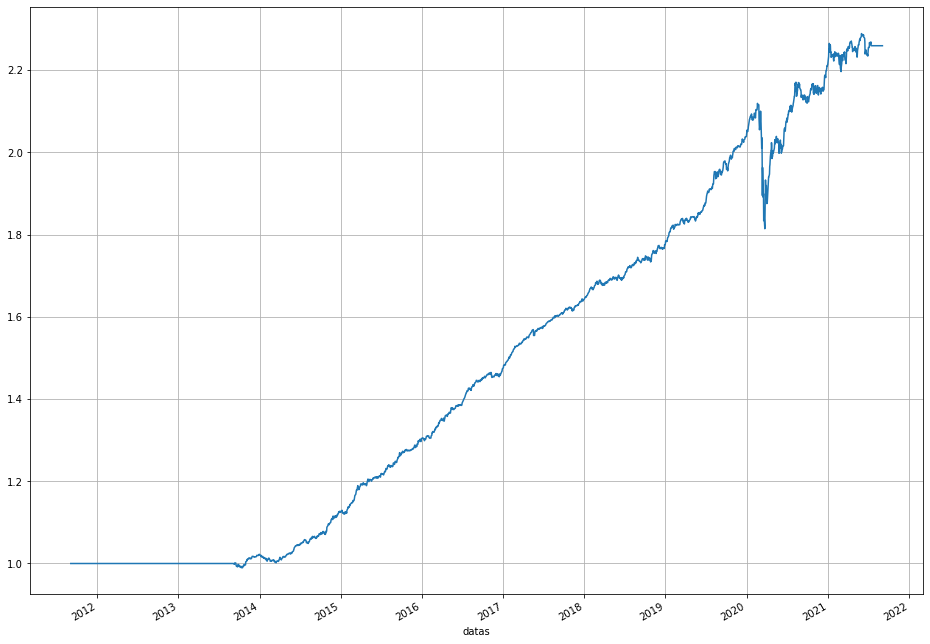

In [73]:
((matriz_pesos.iloc[255][:]) * (DF_retorno_completo.iloc[255][:])).sum()

retorno_perc_carteira = (matriz_pesos * DF_retorno_completo).sum(axis=1)

retorno_acum_carteira = (retorno_perc_carteira + 1).cumprod()
fig = retorno_acum_carteira.plot(figsize = (16,12), grid=True)
retorno_acum_carteira

#fig.get_figure().savefig('Carteira_Arrojado.pdf')

#retorno_acum_carteira_arrojado = retorno_acum_carteira.copy()

In [ ]:
from math import pow

pow(2.674955, 1/9.5)

In [ ]:
mes_atual = mes_inicial
anos_escolhidos = [str(j) for j in range(ano_inicial, ano_final + 1)]
datas_escolhidas = list()
for i in anos_escolhidos:
    while(True):
        if( (int(i) == ano_final) and (mes_atual > mes_final)):
            break
        datas_escolhidas.append( (i, str(mes_atual).zfill(2)) )
        if (mes_atual + intervalo_mensal) <= 12:
            mes_atual += intervalo_mensal
        else:
            mes_atual = (mes_atual + intervalo_mensal) % 12
            break

datas_escolhidas

## LOOP Principal: Resolvendo os modelos em cada período da janela rolante:

In [ ]:
import time

hist = dict()

pf = pd.read_excel('perfilfundos.xlsx', usecols = ['CNPJ', 'APLICACAO_MINIMA', 'CATEGORIA', 'SUBCATEGORIA'])
pf['CNPJ'] = pf['CNPJ'].apply(lambda x: re.sub('\W+', '', x))
pf['APLICACAO_MINIMA'] = pd.to_numeric(pf['APLICACAO_MINIMA'].apply(lambda x : re.sub('\D+', '', x)), errors='coerce')
pf.fillna(0, inplace=True)
pf.set_index('CNPJ',inplace=True)
pf_ordered = pf.sort_values(by ='CATEGORIA')
pf_ordered.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)

cnpj = list(pf_ordered.index)
    
df = df[cnpj]
categorias = list(pf_ordered['CATEGORIA'].unique())
limites = [0]
a = 0
for c in categorias:
    a += len(pf_ordered[pf_ordered['CATEGORIA'] == c])
    limites.append(a)

minFundos = np.array(pf_ordered['APLICACAO_MINIMA'])

n = len(minFundos)

    
DF_iteracao = None

if(len(datas_escolhidas) <= 1):
    print('--- CASO ANTERIOR ---')
else:
    for idx in range(len(datas_escolhidas) - 1):
        DF_iteracao = df.loc[datas_escolhidas[idx][0]+'-'+datas_escolhidas[idx][1] : 
                             datas_escolhidas[idx+1][0]+'-'+datas_escolhidas[idx+1][1]]
        
        df_retorno = DF_iteracao.pct_change().dropna()
        sigma = (df_retorno.cov()*252).to_numpy()
        media = (df_retorno+1).apply(geo_mean)**252-1

        tempo_init = time.time()
        modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
        n, minFundos, sigma, media, cnpj)
        Carteira = modelo.solve()
        print('Tempo total:', time.time() - tempo_init, 's')

        Carteira.exibir(C)

        hist[datas_escolhidas[idx][0], datas_escolhidas[idx][1]] = Carteira
        print('Resultado referente ao periodo: ', datas_escolhidas[idx][0] + '-' + datas_escolhidas[idx][1])
        print('\n')
        print('###############################################')
        print('\n')
        
        DF_iteracao = None

## Plot "validação" para um fundo:

    -) Em azul: a série temporal usada para a previsão dos retornos;
    -) Em vermelho: a série temporal dos seis próximos meses (período do investimento);
    -) Em laranja: a série temporal do mês após o final do investimento.

In [ ]:
hist['2012', '01'].exibir(C)

fundo = '13001211000190'
fundo_ruim = '12120451000141'

df['2012-01':'2012-07-03'][fundo].plot(style = '-b', figsize = (12, 8))
df['2012-07':'2013-01-03'][fundo].plot(style = '--r')
fig = df['2013-01'][fundo].plot(style = '--', color='orange', grid=True)

#fig.get_figure().savefig('Figura1.pdf')

In [ ]:
#sigma[63]


In [ ]:
print(hist.keys())
print()

#Hist['2014', '01'].exibir(C)

# Previsão X Resultado - Ano de 2012:

`Observação:` Os dados foram convertidos em **escores Z** para o plot poder ser colocado em escala!

### Saída do modelo - Fundos escolhidos tomando por base o período 2012/01 ~ 2012/06:

In [ ]:
import cufflinks as cf
from plotly.offline import plot, iplot

cf.go_offline()

dados_periodo = df.loc['2012-01':'2012-06']

cnpj_periodo = hist['2012', '01'].descricao

series_temp = dados_periodo[cnpj_periodo]

series_temp = (series_temp - series_temp.mean())/series_temp.std()

series_temp.iplot()


### Seis próximos meses - Resultado da aplicação selecionada

In [ ]:
import cufflinks as cf
from plotly.offline import plot, iplot

cf.go_offline()

dados_periodo = df.loc['2012-07':'2013-01']

cnpj_periodo = hist['2012', '01'].descricao

series_temp = dados_periodo[cnpj_periodo]

series_temp = (series_temp - series_temp.mean())/series_temp.std()

series_temp.iplot()


In [ ]:
resultados

res_np = np.array(resultados)

res_np = res_np.cumprod() * 100_000

res_np

In [ ]:
res_pd = pd.DataFrame(res_np)

res_pd.columns = ['Capital']
res_pd.index = ['01/2012', '07/2012', '01/2013', '07/2013', '01/2014', '07/2014', '01/2015', '07/2015', '01/2016']
res_pd

In [ ]:
figura = res_pd.plot(figsize = (14,8), ylim = (90_000, 150_000))


In [ ]:
fig = plt.figure() 
plt.figure(figsize=(8,6))
plt.plot(res_np)
plt.grid()
#plt.xlabel('VOLATILIDADE ESPERADA')
#plt.ylabel('RETORNO ESPERADO')
#plt.savefig('conservador.pdf')
plt.show()